<h1 align="center">BSc Thesis</h1>

<h2 align="center">Parkinson’s disease and the Medial Geniculate Nucleus: <br/> A 7-Tesla MRI comparison of structural volume between patients and healthy controls</h2>


In [1]:
%load_ext rpy2.ipython

# python packages
import os
import sys
import numpy as np
import pandas as pd
from statistics import stdev
from scipy.stats import mannwhitneyu

# to run R code in python
import rpy2.robjects.numpy2ri
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# my python packages
sys.path.insert(1, 'src')
from visualizations import boxplots, scatterplots
from dataProcessing import getFinalData
sys.path.insert(1, 'src/BayesianMannWhitneyTest')
from truncation import *
from gibbs import *
from BayesFactorWilcoxon import *

C:\Users\odyse\anaconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
def BayesFactor(data):
    volHC = data.loc[data['group'] == "HC"]["meanVol"]
    volPD = data.loc[data['group'] == "PD"]["meanVol"]
    # ignore warning
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
    result = rankSumGibbsSampler(volHC, volPD, nBurnin=1)
    rHat = result[0]
    deltaSamplesMatrixFlat = result[2]
    # pass variable to R
    %R -i deltaSamplesMatrixFlat
    # define R variable
    %R -o vec vec = as.vector(deltaSamplesMatrixFlat)
    rpy2.robjects.numpy2ri.activate()
    # one-sided hypothesis: healthy controls will have a greater mean than pd patients
    bf = computeBayesFactorWilcoxon(vec, 1/sqrt(2), "right")[0]
    U, p = mannwhitneyu(volHC, volPD, method="exact")
    
    median, low, high = posteriorCRI(onesided="right", deltaSamples=deltaSamplesMatrixFlat, criVal=0.95)
    
    n = len(volHC.index)
    posteriorMedian = round(median, 2),
    CRI = [round(low, 2), round(high, 2)]
    meanHC = np.mean(volHC)
    sdHC = stdev(volHC)
    meanPD = np.mean(volPD)
    sdPD = stdev(volPD)
    
    out = [n, bf, median, CRI, meanHC, sdHC, meanPD, sdPD]
    
    # an rHat of ~ 1 shows that there was convergence, which is what we want
    print("\nrHat =", rHat)
    print("BF10 =", bf)
    print("U statistic =", U, "\n")
    
    return out

In [3]:
def simulatedBayesFactors(simSampleSizes):
    results = []
    print("Be patient, the simulation takes several minutes :) \n")
    for i in simSampleSizes:
        simData = pd.read_csv("outputData/simulatedData" + i + ".csv")
        print("Now computing BF for simulated data with n = " + i)
        results.append(BayesFactor(simData))
    
    simBFs = pd.DataFrame(data=results, 
                          columns=["n", "BF10", "posteriorMedian", "95% CRI", "meanHC", "sdHC", "meanPD", "sdPD"])
        
    return simBFs

In [8]:
def outputResults(mainResult, simResults):
    resultDF = pd.DataFrame(data=[mainResult], 
                            columns=["n", "BF10", "posteriorMedian", "95% CRI", "meanHC", "sdHC", "meanPD", "sdPD"])
    display(resultDF)
    display(simResults)
    
    if not os.path.exists("results"):
        os.mkdir("results")
    resultDF.to_csv("results/result.csv")
    simResults.to_csv("results/simulatedBFs.csv")

For the healthy controls, the difference between the left (M = 122.81 SD = 37.43 )
and the right (M = 120.76 SD = 37.83 ) hemisphere is not statistically significant
W = 30.0 p = 0.8310546875 for a two-sided alternative hypothesis.

For the PD patients, the difference between the left (M = 99.99 SD = 36.16 )
and the right hemisphere (M = 105.94 SD = 32.54 ) is not statistically significant
W = 27.0 p = 0.6376953125 for a two-sided alternative hypothesis.



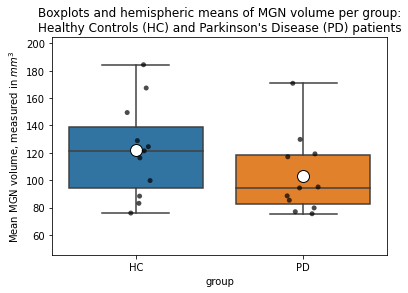

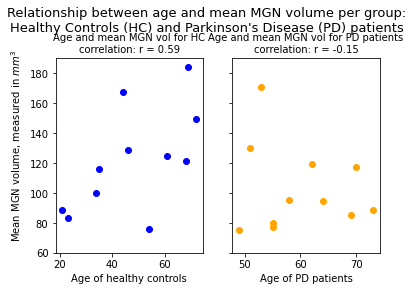

Starting chain:  1 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1000
Starting chain:  2 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1000
Starting chain:  3 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1000
Starting chain:  4 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1000
Starting chain:  5 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1000

rHat = 1.0015711575583561
BF = 1.2244502123559273
U statistic = 80.0 

Be patient, the simulation takes several minutes :) 

Now computing BF for simulated data with n = 11
Starting chain:  1 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1000
Starting chain:  2 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1000
Starting chain:  3 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1000
Starting chain:  4 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1000
Starting chain:  5 / 5
	Now at iteration:  1 / 1000
	Now at iteration:  501 / 1

,n,BF,posteriorMedian,95% CRI,meanHC,sdHC,meanPD,sdPD
0,11,1.22445,0.457288,"[0.03, 1.16]",121.784094,34.701364,102.965909,29.000517


,n,BF,posteriorMedian,95% CRI,meanHC,sdHC,meanPD,sdPD
0,11,0.735111,0.348643,"[0.02, 1.01]",116.602780,35.676397,102.987514,28.324177
1,15,2.413374,0.555121,"[0.05, 1.25]",126.692531,35.282418,101.873059,24.398572
2,20,1.597037,0.461625,"[0.04, 1.02]",120.721133,31.501187,105.190203,29.118278
3,30,16.098809,0.674783,"[0.19, 1.19]",127.065421,25.697212,105.659567,28.261729
4,50,21.917864,0.564410,"[0.17, 0.95]",119.101344,32.689831,98.923458,27.399379
5,75,76.049982,0.581957,"[0.26, 0.91]",120.275845,29.816006,99.468072,24.088803


In [9]:
def main():
    data = getFinalData()
    boxplots(data)
    scatterplots(data)
    
    result = BayesFactor(data)
    simSampleSizes = ["11", "15", "20", "30", "50", "75"]
    simBFs = simulatedBayesFactors(simSampleSizes)
    outputResults(result, simBFs)

main()